Zane Enochs and Mac Sumner



DATA AND PURPOSE OF THE PROJECT

Link to dataset: https://www.kaggle.com/datasets/alfredkondoro/exploring-kobe-bryants-nba-journey/data

Our dataframe contained the player statistics for Michael Jordan's NBA career, giving the points, assists, outcome, and several other statistics for each game he played. Our goal was to get insight on the relationship between the player's individual performance and the success of the team.

We took Michael Jordan's stats from every single game he played in and tried to predict the result of the game based on his performance, using different stats to see which had a significant impact.



ANALYSIS OF THE DATA

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
mj_data = pd.read_csv('data/michaeljordan.csv')
mj_data.head()

,season,date,team_played,game_type,venue,opponent,win_lose,point_difference,game_started,minutes_played,...,freethrow_percent,offensive_rebounds,defensive_rebounds,total_rebounds,assists,steals,blocks,turnovers,personal_fouls,points
0,1.0,10/26/1984,chicago bulls,season,home,washington bullets,w,16.0,1.0,40:00:00,...,0.857,1.0,5.0,6.0,7.0,2.0,4.0,5.0,2.0,16.0
1,1.0,10/27/1984,chicago bulls,season,away,milwaukee bucks,l,2.0,1.0,34:00:00,...,1.000,3.0,2.0,5.0,5.0,2.0,1.0,3.0,4.0,21.0
2,1.0,10/29/1984,chicago bulls,season,home,milwaukee bucks,w,6.0,1.0,34:00:00,...,0.846,2.0,2.0,4.0,5.0,6.0,2.0,3.0,4.0,37.0
3,1.0,10/30/1984,chicago bulls,season,away,kansas city kings,w,5.0,1.0,36:00:00,...,1.000,2.0,2.0,4.0,5.0,3.0,1.0,6.0,5.0,25.0
4,1.0,11/1/1984,chicago bulls,season,away,denver nuggets,l,16.0,1.0,33:00:00,...,0.750,3.0,2.0,5.0,5.0,1.0,1.0,2.0,4.0,17.0


In [47]:
row_count = len(mj_data)
row_count

1266

minutes_played is formatted as 40:00:00 so we converted it to a float format

In [6]:
def time_to_minutes(time_val):
    if isinstance(time_val, str):
        parts = time_val.split(':')
        
        if len(parts) == 2:
            return int(parts[0]) * 60 + int(parts[1])
        elif len(parts) == 3:
            return int(parts[1]) + int(parts[2]) / 60  
    elif pd.notnull(time_val):
        return float(time_val)
    else:
        return 0 
mj_data['minutes_played'] = mj_data['minutes_played'].apply(time_to_minutes)

Next we tried to visualize the data

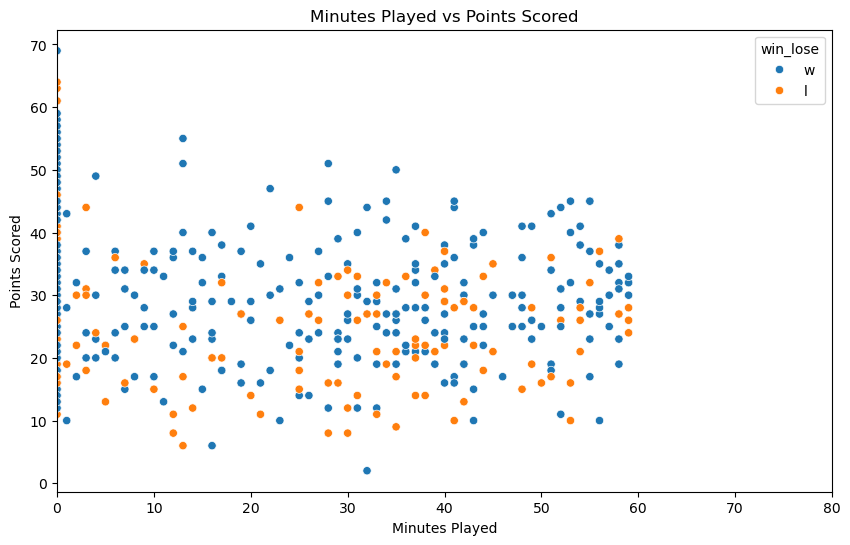

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='minutes_played', y='points', hue='win_lose', data=mj_data)
plt.title("Minutes Played vs Points Scored")
plt.xlabel("Minutes Played")
plt.ylabel("Points Scored")

# Set limits for the x-axis (for example, 0 to 48)
plt.xlim(0, 80)

plt.show()

The graph above displays the relationship between Jordan's minutes played and points scored

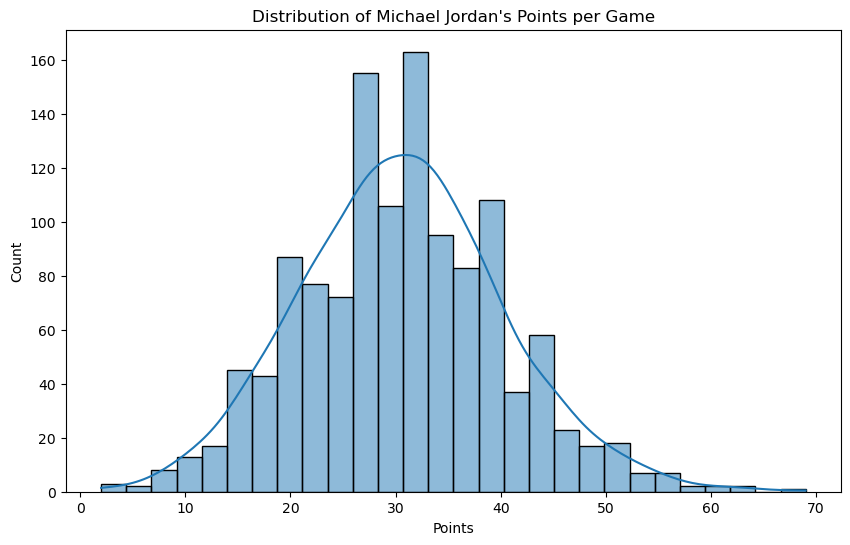

In [10]:
#This is a distribution of his points per game
plt.figure(figsize=(10, 6))
sns.histplot(mj_data['points'], kde=True)
plt.title("Distribution of Michael Jordan's Points per Game")
plt.xlabel("Points")
plt.ylabel("Count")
plt.show()

This histogram shows the distribution of his points per game. The count shows how many time he scored that amount of points.

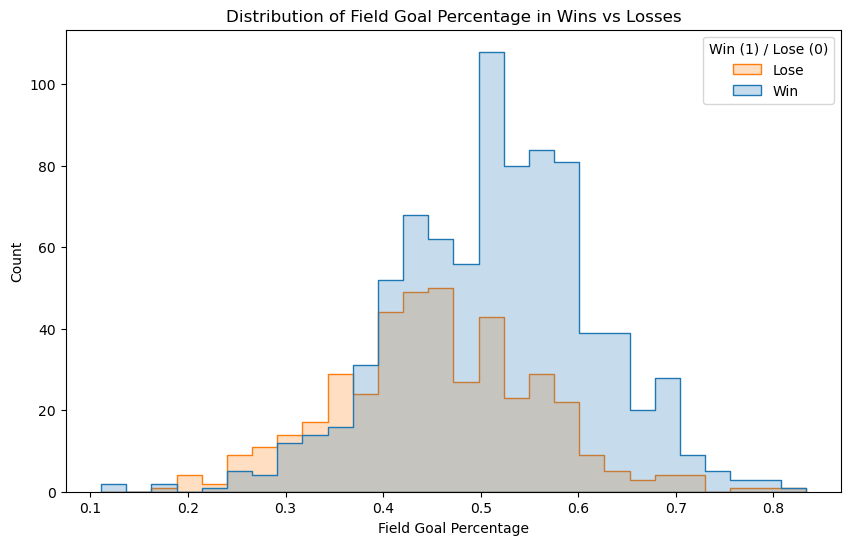

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(data=mj_data, x='fieldgoal_percent', hue='win_lose', element='step', stat='count', common_norm=False)
plt.title("Distribution of Field Goal Percentage in Wins vs Losses")
plt.xlabel("Field Goal Percentage")
plt.ylabel("Count")
plt.legend(title='Win (1) / Lose (0)', labels=['Lose', 'Win'])
plt.show()

This shows the distribution of his Field Goal% in wins and losses. We can see he typically had a higher percentage in wins

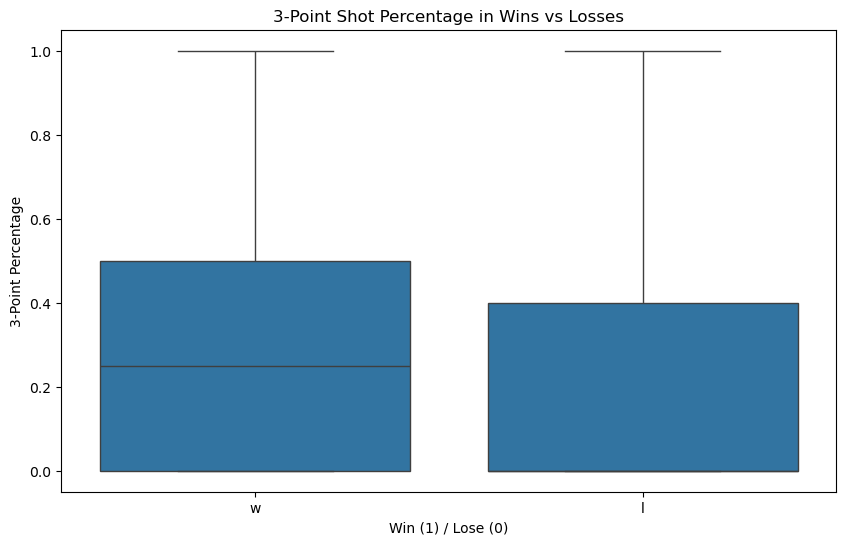

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='win_lose', y='3pointers_percent', data=mj_data)
plt.title("3-Point Shot Percentage in Wins vs Losses")
plt.xlabel("Win (1) / Lose (0)")
plt.ylabel("3-Point Percentage")
plt.show()

This boxplot displays his 3pt% in wins vs losses. We can see there is a higher median line in wins, meaning on average he had a higher 3pt% in wins

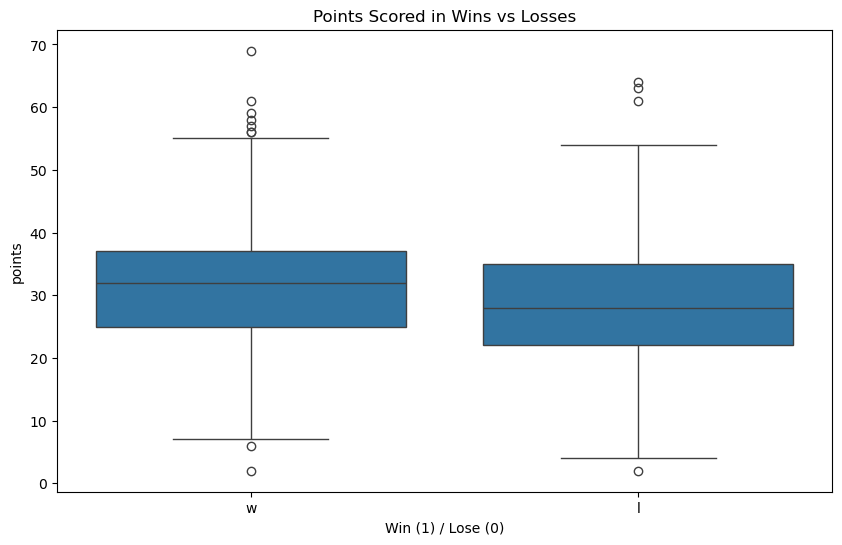

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='win_lose', y='points', data=mj_data)
plt.title("Points Scored in Wins vs Losses")
plt.xlabel("Win (1) / Lose (0)")
plt.show()

Just like the boxplot before the median line is higher when he wins, meaning he typically scored more points in wins

Next we made a correlation matrix that filters it so it's only numeric columns

SOLVING THE PROBLEM: For our analysis of the relation between Michael Jordan's points scored and the outcome of the game,
we decided to use a confusion matrix with a threshold. For the displayed heat map- we used a threshold of 25 points of more
to predict a win for that game. If Michael scored less than 25, a loss was predicted.

In [20]:
#Organize data
mj_data_cleaned = mj_data[['points', 'win_lose',]].copy()

mj_data_cleaned['points'] = pd.to_numeric(mj_data_cleaned['points'], errors='coerce').fillna(0).astype(int)
#kobe_data['assists'] = pd.to_numeric(kobe_data['assists'], errors='coerce').fillna(0).astype(int)

mj_data_cleaned.tail(10)

,points,win_lose
1256,17,l
1257,22,l
1258,25,w
1259,26,w
1260,21,l
1261,25,w
1262,17,l
1263,21,l
1264,15,l
1265,0,NaN


In [21]:
#Remove Null and NaN
mj_data_cleaned.replace('Null', pd.NA, inplace=True)
mj_data_cleaned = mj_data_cleaned.dropna()
mj_data_cleaned.dropna(inplace=True)
mj_data_cleaned.tail(10)

,points,win_lose
1255,19,l
1256,17,l
1257,22,l
1258,25,w
1259,26,w
1260,21,l
1261,25,w
1262,17,l
1263,21,l
1264,15,l


In [22]:
#Convert 'points' column to integer
mj_data_cleaned['points'] = mj_data_cleaned['points'].astype(int)
# kobe_data_cleaned['assists'] = kobe_data_cleaned['assists'].astype(int)

#Convert 'win_lose' column to integers (1 for 'w', 0 for 'l')
mj_data_cleaned['win_lose'] = mj_data_cleaned['win_lose'].map({'w': 1, 'l': 0})

mj_data_cleaned.tail(10)

,points,win_lose
1255,19,0
1256,17,0
1257,22,0
1258,25,1
1259,26,1
1260,21,0
1261,25,1
1262,17,0
1263,21,0
1264,15,0


In [23]:
#Separate 'win_lose' 
labels = mj_data_cleaned['win_lose']

#drop 'win_lose' column features
features = mj_data_cleaned.drop(columns=['win_lose'])

#Check features
features.tail(10)

,points
1255,19
1256,17
1257,22
1258,25
1259,26
1260,21
1261,25
1262,17
1263,21
1264,15


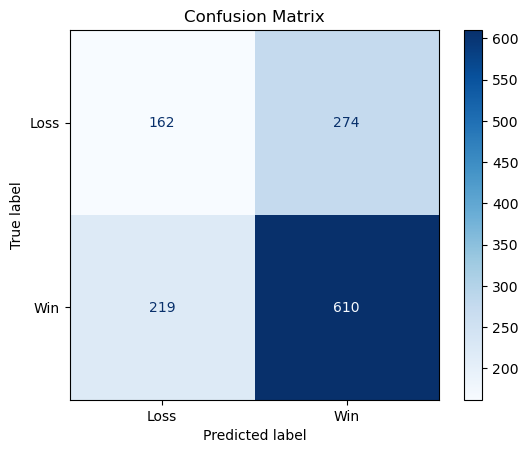

In [24]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Split data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=100)

#KNN classifier and prediction
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

threshold = 25

#Create predictions based on the threshold
predictions = (mj_data_cleaned['points'] > threshold).astype(int)

#Create confusion matrix
cm = confusion_matrix(mj_data_cleaned['win_lose'], predictions)

#Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Loss', 'Win'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [28]:
#Test with different thresholds
thresholds = [10,15,20, 25, 30, 35]  # Example thresholds
results = []

for threshold in thresholds:
    #  Create predictions based on the current threshold
    predictions = (mj_data_cleaned['points'] > threshold).astype(int)
    
    #  Create confusion matrix
    cm = confusion_matrix(mj_data_cleaned['win_lose'], predictions)
    
    # Calculate accuracy
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum() if cm.sum() > 0 else 0
    results.append((threshold, accuracy))

#Display results
for threshold, accuracy in results:
    print(f'Threshold: {threshold}, Accuracy: {accuracy:.2f}')

Threshold: 10, Accuracy: 0.66
Threshold: 15, Accuracy: 0.66
Threshold: 20, Accuracy: 0.65
Threshold: 25, Accuracy: 0.61
Threshold: 30, Accuracy: 0.56
Threshold: 35, Accuracy: 0.47


Our analysis through heat mapping indicated that the threshold of 25 points is moderately accurate in predicting the outcome of 
each game. While the model accurately predicted 610 wins when he scored over 25 points, it also generated a significant number of false positives (274), incorrectly predicting wins for games where he scored less than this threshold. Additionally, the presence of 219 false negatives indicates that there were instances where he scored over 25 points but still lost, suggesting that scoring alone does not guarantee victory. These results highlight the need to consider other factors influencing game outcomes. Additionally, as the threshold increases, the accuracy of the model decreases, indicating that the team's success is not predicted more accurately as his individual performance climbs higher. Overall, the data suggests that while higher scoring thresholds intuitively seem to represent stronger performance, they may inadvertently limit the model's effectiveness by excluding important win scenarios. This highlights the need for a balanced approach in threshold selection, where a lower threshold captures more successful predictions, but might also increase the risk of false positives.

The confusion matrix is an effective tool for evaluating the relationship between Michael Jordan’s points scored and his team’s likelihood of winning because it provides a clear breakdown of prediction accuracy across different categories: true positives, false positives, true negatives, and false negatives. In this analysis, the confusion matrix helps assess how well a specific threshold of points, like 25, predicts a win or a loss. By comparing the model’s predictions with the actual game outcomes, it quantifies how often the model correctly identifies a win (true positives) or a loss (true negatives), and how often it makes incorrect predictions, such as predicting a win when there wasn’t one (false positives) or failing to predict a win when there was one (false negatives).

For example, a high number of false positives could suggest that the threshold is too high, causing the model to overestimate the likelihood of a win based solely on points. On the other hand, false negatives could indicate that the model underestimates the importance of Jordan’s scoring in some instances where his performance might still result in a win despite falling below the threshold. This breakdown is crucial because it not only shows how well the model predicts wins but also highlights areas where the model can be improved.

The confusion matrix also helps visualize the trade-offs between sensitivity (true positive rate) and specificity (true negative rate) as the threshold changes. By evaluating different thresholds through this matrix, one can identify the optimal balance where the model minimizes both false positives and false negatives, leading to a more reliable and nuanced understanding of how Jordan’s scoring impacts game outcomes. This approach emphasizes that scoring alone may not be sufficient to predict a win, and other factors, such as the team's overall performance, must also be considered.
